In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Import dependencies
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import transforms
try:
  from torchinfo import summary
except:
  print(f"[INFO] Couldn't find torchinfo...installing")
  !pip install -q torchinfo
  from torchinfo import summary

try:
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves
except:
  print(f"[INFO] going_modular or helper_function script not found...installing")
  !git clone https://github.com/mrdbourke/pytorch-deep-learning
  !mv pytorch-deep-learning/going_modular .
  !mv pytorch-deep-learning/helper_functions.py .
  !rm -rf pytorch-deep-learning
  from going_modular.going_modular import data_setup, engine
  from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] going_modular or helper_function script not found...installing
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4183, done.
remote: Counting objects: 100% (148/148), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 4183 (delta 63), reused 109 (delta 41), pack-reused 4035 (from 1)
Receiving objects: 100% (4183/4183), 652.89 MiB | 34.46 MiB/s, done.
Resolving deltas: 100% (2434/2434), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# download data from github
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_sushi_steak")
image_path

[INFO] Did not find data/pizza_sushi_steak directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


PosixPath('data/pizza_sushi_steak')

In [5]:
# Setup directory to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [6]:
# Preparing transforms for images
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [7]:
# Set the batch size
BATCH_SIZE = 32

# Create dataloaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7d11a3b6ee00>,
 ['pizza', 'steak', 'sushi'])

In [8]:
# get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get a single image from the batch
image, label = image_batch[0], label_batch[0]

# view batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

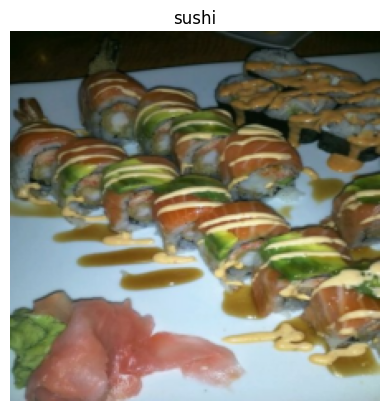

In [9]:
# plot image with matplotlib
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [10]:
# Calculate patch embedding input and output shapes
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate number of patches
number_of_patches = int((height*width)/patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [11]:
# input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


(-0.5, 223.5, 223.5, -0.5)

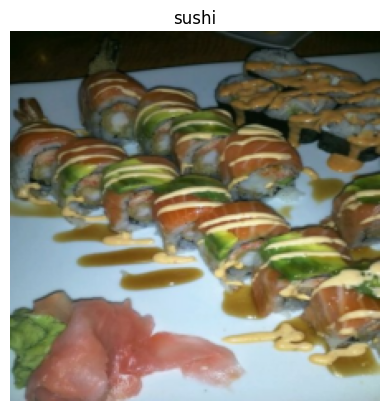

In [12]:
# view single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

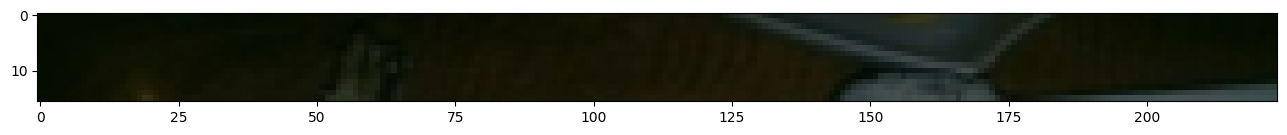

In [13]:
# Turning the single image into patches

# change image shape to be compatible with matplotlib 
image_permuted = image.permute(1,2,0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


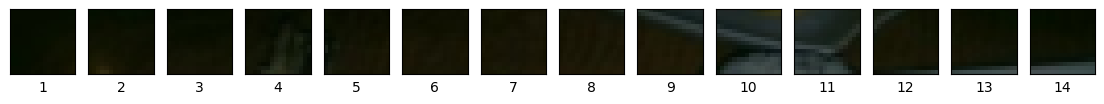

In [14]:
# set hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])

Number of patches per row: 14.0 | 
Number of patches per column: 14.0 | 
Total patches: 196.0 | 
Patch Size: 16 pixels x 16 pixels


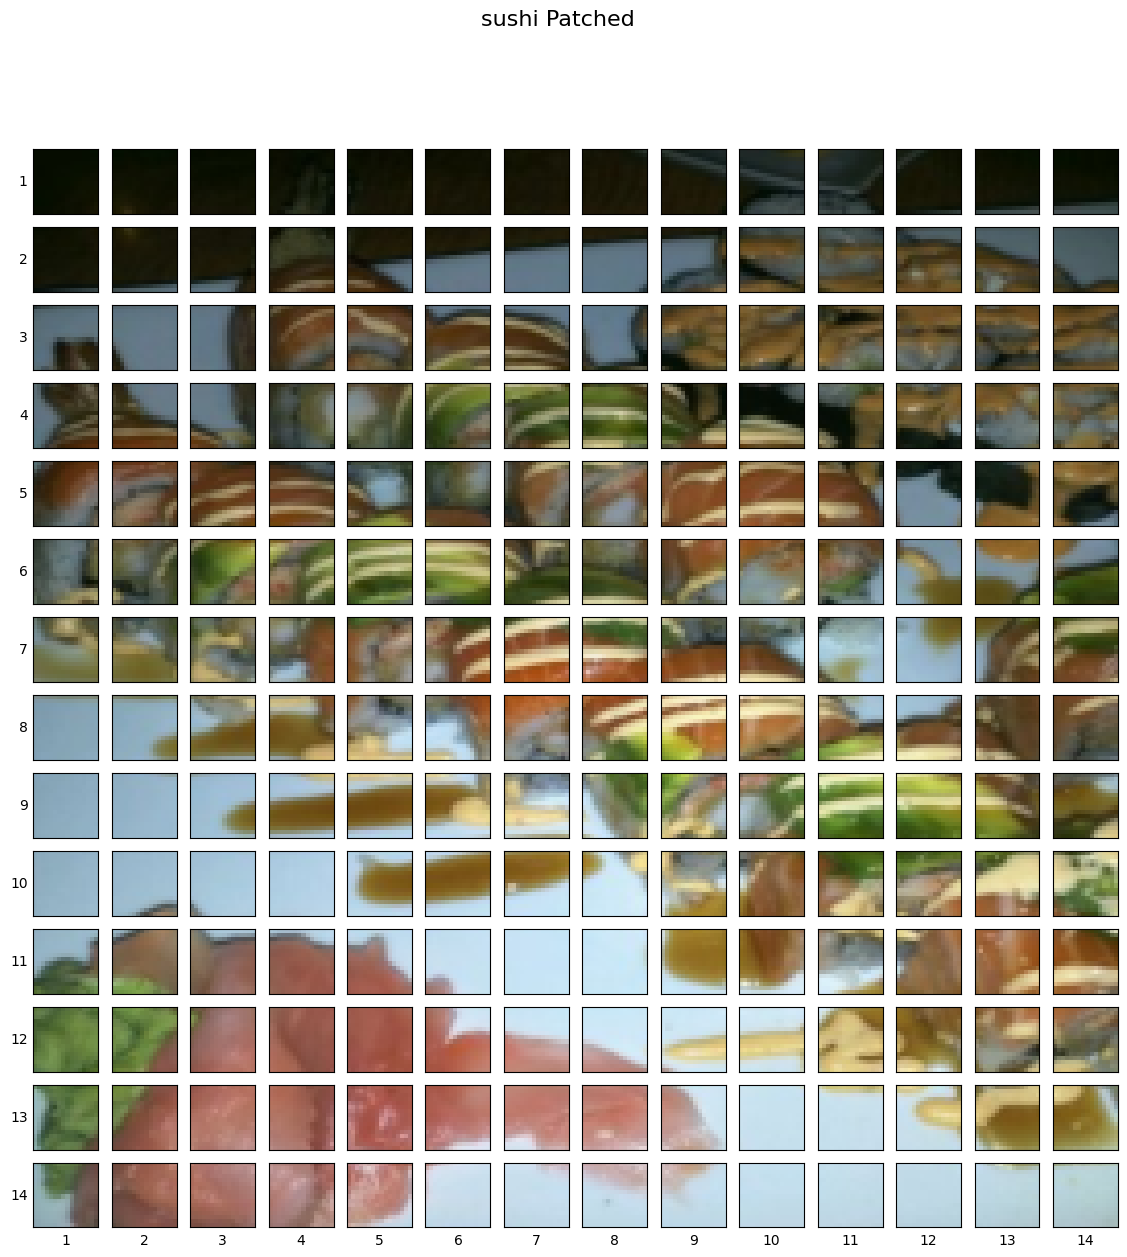

In [15]:
# Plotting for the whole image
# setup hyperparameters
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0 
print(f"Number of patches per row: {num_patches} | \nNumber of patches per column: {num_patches} | \nTotal patches: {num_patches*num_patches} | \nPatch Size: {patch_size} pixels x {patch_size} pixels")

# create series of subplots
fig, axs = plt.subplots(nrows=img_size//patch_size,
                        ncols=img_size//patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    # Plot the permuted image patch
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :])
    # set up label information, remove ticks for clarity
    axs[i, j].set_ylabel(i+1,
                         rotation="horizontal",
                         horizontalalignment="right",
                         verticalalignment="center")
    axs[i , j].set_xlabel(j+1)
    axs[i, j].set_xticks([])
    axs[i, j].set_yticks([])
    axs[i, j].label_outer()

# set a super title
fig.suptitle(f"{class_names[label]} Patched", fontsize=16)
plt.show()

In [16]:
# Creating image patches with Conv2d
patch_size = 16

# create Conv2D layer with parameters from Vit paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

(-0.5, 223.5, 223.5, -0.5)

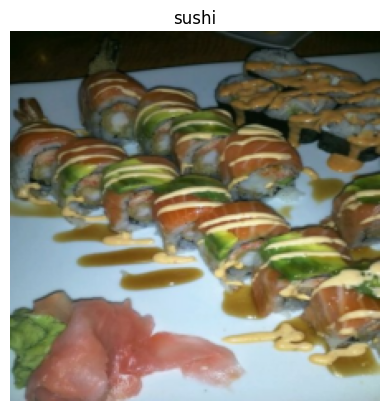

In [17]:
# Let's observe what happens when a single image is passed through the conv layer
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [18]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


showing random convolutional feature maps from indexes: [589, 64, 663, 47, 398]


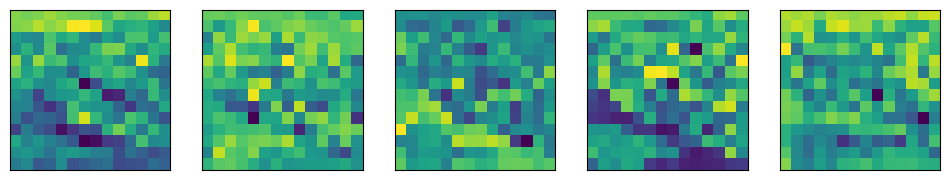

In [19]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"showing random convolutional feature maps from indexes: {random_indexes}")

# create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# plot random image feature maps
for i, idx in enumerate(random_indexes):
  image_conv_feature_map = image_out_of_conv[:, idx, :, :]
  axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [20]:
# get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[-0.0518, -0.0611, -0.0566, -0.0360, -0.0717, -0.0673, -0.0807,
           -0.0835, -0.1496, -0.1802, -0.1774, -0.0959, -0.1015, -0.0962],
          [-0.0748, -0.1550, -0.1381, -0.2373, -0.1145, -0.2577, -0.3345,
           -0.3743, -0.3543, -0.2582, -0.3650, -0.3960, -0.3468, -0.4124],
          [-0.4418, -0.5661, -0.4605, -0.2812, -0.3357, -0.3703, -0.3279,
           -0.5565, -0.3896, -0.4178, -0.3002, -0.3569, -0.2975, -0.3275],
          [-0.3139, -0.3579, -0.5004, -0.3563, -0.3850, -0.3769, -0.4205,
           -0.4159, -0.2419, -0.2205, -0.2088, -0.3795, -0.4012, -0.3812],
          [-0.2093, -0.4111, -0.2590, -0.4198, -0.4405, -0.2895, -0.3517,
           -0.4908, -0.3748, -0.5090, -0.3318, -0.5289, -0.1789, -0.2703],
          [-0.5095, -0.3701, -0.3751, -0.4307, -0.5055, -0.6396, -0.3071,
           -0.4398, -0.4105, -0.4679, -0.4589, -0.6435, -0.4669, -0.4151],
          [-0.5206, -0.5252, -0.4637, -0.4454, -0.5420, -0.4046, -0.8115,
           -0.5283, -0.4992, -0.

In [21]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [22]:
# Create a flatten layer to flatten the spatial dimensions of the feature map
flatten = nn.Flatten(start_dim=2,
                     end_dim=3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


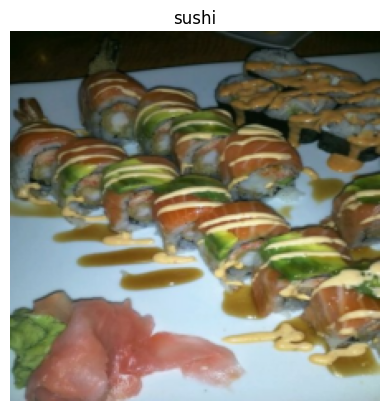

In [23]:
# View single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape: {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0))
print(f"Image feature map shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [24]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0,2,1)
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


(-0.5, 195.5, 0.5, -0.5)

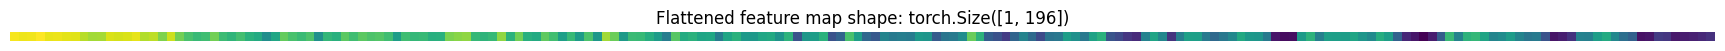

In [25]:
# get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0]


# plot the flattened feature map visually
plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False)

In [26]:
# see the flattened feature map as a tensor
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0518, -0.0611, -0.0566, -0.0360, -0.0717, -0.0673, -0.0807, -0.0835,
          -0.1496, -0.1802, -0.1774, -0.0959, -0.1015, -0.0962, -0.0748, -0.1550,
          -0.1381, -0.2373, -0.1145, -0.2577, -0.3345, -0.3743, -0.3543, -0.2582,
          -0.3650, -0.3960, -0.3468, -0.4124, -0.4418, -0.5661, -0.4605, -0.2812,
          -0.3357, -0.3703, -0.3279, -0.5565, -0.3896, -0.4178, -0.3002, -0.3569,
          -0.2975, -0.3275, -0.3139, -0.3579, -0.5004, -0.3563, -0.3850, -0.3769,
          -0.4205, -0.4159, -0.2419, -0.2205, -0.2088, -0.3795, -0.4012, -0.3812,
          -0.2093, -0.4111, -0.2590, -0.4198, -0.4405, -0.2895, -0.3517, -0.4908,
          -0.3748, -0.5090, -0.3318, -0.5289, -0.1789, -0.2703, -0.5095, -0.3701,
          -0.3751, -0.4307, -0.5055, -0.6396, -0.3071, -0.4398, -0.4105, -0.4679,
          -0.4589, -0.6435, -0.4669, -0.4151, -0.5206, -0.5252, -0.4637, -0.4454,
          -0.5420, -0.4046, -0.8115, -0.5283, -0.4992, -0.4087, -0.8157, -0.7466,
          -0.336

In [27]:
# putting it all together in a pytorch module
class PatchEmbedding(nn.Module):
  def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
    super().__init__()
    self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0
                                )
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)
    
  def forward(self, x):
    # create assertion to check inputs are in the correct shape
    image_resolution = x.shape[-1]
    assert image_resolution % patch_size == 0

    return self.flatten(self.patcher(x)).permute(0,2,1)


In [28]:
set_seeds()
# Create an instance of patch embedding layer
patcher = PatchEmbedding(in_channels=3,
                         patch_size=16,
                         embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patcher(image.unsqueeze(0))
print(f"Output batch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output batch embedding shape: torch.Size([1, 196, 768])


In [29]:
# getting the summary of the patchembedding layer
# Create random input sizes
random_input_image = (1, 3, 224, 224)

summary(PatchEmbedding(),
        input_size=random_input_image,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [30]:
# Implementing equation 1 from the ViT Paper
set_seeds()

# set patch size
number_of_patches = 16

# print shape of original image tensor and get the image dimension
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"patch embedding shape: {patch_embedding.shape}")


# create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f"Class token embedding shape: {class_token.shape}")

# prepend class token embedding to patch embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_with_class_token.shape}")

# cretae position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

# Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_with_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


In [31]:
# Implementing equation 2 from the ViT paper
class MultiheadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dim=768,
               num_heads=12,
               attn_dropout=0):
    super().__init__()

    # create the Norm layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # Create multihead attention layer(MSA)
    self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                num_heads=num_heads,
                                                dropout=attn_dropout,
                                                batch_first=True)
    
    # create a forward method to pass the data through the layers
  def forward(self, x):
    x = self.layer_norm(x)
    attn_output, _ = self.multihead_attn(query=x,
                                          key=x,
                                          value=x,
                                          need_weights=False)
    return attn_output


In [32]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(
    embedding_dim=768,
    num_heads=12
)

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [33]:
# Implementing equation 3 of the ViT Paper
class MLPBlock(nn.Module):
  def __init__(self, 
               embedding_dim=768,
               mlp_size=3072,
               dropout=0.1
               ):
  
    super().__init__()

    # Create the Norm Layer
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

    # create multilayer perceptron
    self.mlp = nn.Sequential(
        nn.Linear(in_features=embedding_dim,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embedding_dim),
        nn.Dropout(p=dropout)
    )

    # Create a forward() method to pass the data through layers
  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x
    

In [34]:
# Create an instance of MLPBlock
mlp_block  = MLPBlock(embedding_dim=768,
                      mlp_size=3072,
                      dropout=0.1)

# pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


In [35]:
# Create a Transformer Encoder
class TransformerEncoderBlock(nn.Module):
  def __init__(self,
               embedding_dim=768,
               num_heads=12,
               mlp_size=3072,
               mlp_dropout=0.1,
               attn_dropout=0):
    super().__init__()

    # Create MSA block from equation 2
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 attn_dropout=attn_dropout)
    
    # create MLP block
    self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                              mlp_size=mlp_size,
                              dropout=mlp_dropout)
    
    # create a forward() method
  def forward(self, x):
    # create residual connection for MSA block
    x = self.msa_block(x) + x

    # create residual connection for MLP block
    x = self.mlp_block(x) + x
    return x

In [36]:
# creeate an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# get summary of the transformer encoder
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"]) 

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [37]:
# Putting it all together to implement ViT
class ViT(nn.Module):
  def __init__(self, 
               img_size=224,
               in_channels=3,
               patch_size=16,
               num_transformer_layers=12,
               embedding_dim=768,
               num_heads=12,
               mlp_size=3072,
               mlp_dropout=0.1,
               attn_drop=0,
               embedding_dropout=0.1,
               num_classes=1000):
    super().__init__()

    # making sure image size is divisible by patch size
    assert img_size % patch_size == 0 

    # calculate the number of patches
    self.num_patches = (img_size*img_size) // patch_size**2

    # creaate learnable class embedding
    self.class_embedding = nn.Parameter(data=torch.randn(1,1,embedding_dim),
                                        requires_grad=True)
    
    # create learnable position embedding
    self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                           requires_grad=True)
    
    # Create embedding dropout value
    self.embedding_dropout = nn.Dropout(p=embedding_dropout)

    # create patsch embedding layer
    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                          patch_size=patch_size,
                                          embedding_dim=embedding_dim)
    
    # create transformer encoder blocks
    self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                         num_heads=num_heads,
                                                                         mlp_size=mlp_size,
                                                                         mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    # create classifier head
    self.classifier = nn.Sequential(
        nn.LayerNorm(normalized_shape=embedding_dim),
        nn.Linear(in_features=embedding_dim,
                  out_features=num_classes)
    )

    # Create a forward() method
  def forward(self, x):
    # get batch size
    batch_size=x.shape[0]

    # craete cass token embedding and expand to match
    class_token = self.class_embedding.expand(batch_size, -1, -1)

    # Create patch embedding
    x = self.patch_embedding(x)

    # concat class embedding and patch embedding
    x = torch.cat((class_token, x), dim=1)

    # Add position embedding to patch embedding
    x = self.position_embedding + x

    # Run embedding dropout
    x = self.embedding_dropout(x)

    # Pass patch, position and class embedding through transformer encoder
    x = self.transformer_encoder(x)

    # put 0 index logit through clasifier
    x = self.classifier(x[:, 0])

    return x


In [38]:
# create an instance of ViT model
set_seeds()

vit = ViT(num_classes=len(class_names))

In [39]:
# get a summary of the ViT model
summary(model=vit,
        input_size=(32, 3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

In [40]:
# training the vit model
from going_modular.going_modular import engine

# setup optimizer 
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

# Setup loss function 
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save results to dictionary
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7627 | train_acc: 0.2917 | test_loss: 1.1868 | test_acc: 0.3625
Epoch: 2 | train_loss: 1.1679 | train_acc: 0.3167 | test_loss: 1.1100 | test_acc: 0.3625
Epoch: 3 | train_loss: 1.1405 | train_acc: 0.3167 | test_loss: 1.0958 | test_acc: 0.3500
Epoch: 4 | train_loss: 1.1142 | train_acc: 0.3250 | test_loss: 1.1453 | test_acc: 0.2875
Epoch: 5 | train_loss: 1.1394 | train_acc: 0.2958 | test_loss: 1.1283 | test_acc: 0.3500
Epoch: 6 | train_loss: 1.1141 | train_acc: 0.3708 | test_loss: 1.2757 | test_acc: 0.3500
Epoch: 7 | train_loss: 1.1958 | train_acc: 0.3229 | test_loss: 1.1471 | test_acc: 0.2875
Epoch: 8 | train_loss: 1.1153 | train_acc: 0.3833 | test_loss: 1.1380 | test_acc: 0.3625
Epoch: 9 | train_loss: 1.1327 | train_acc: 0.3375 | test_loss: 1.1888 | test_acc: 0.2875
Epoch: 10 | train_loss: 1.1720 | train_acc: 0.3000 | test_loss: 1.1770 | test_acc: 0.2875


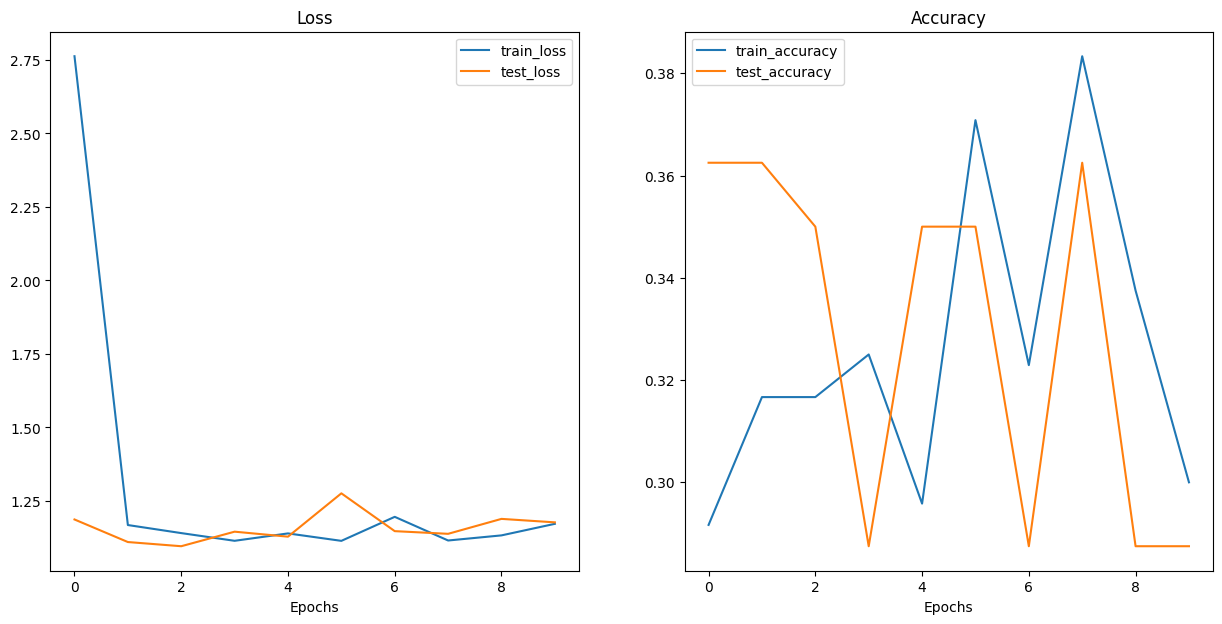

In [41]:
# plot loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(results) 

In [42]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
# change the classifier head
set_seeds() #set the seeds to ensure reproducibiity
pretrained_vit.heads = nn.Linear(in_features=768,
                                out_features=len(class_names)).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 189MB/s]  


In [43]:
# Let's get the summary using torchinfo
summary(model=pretrained_vit,
       input_size=(32,3,224,224),
       col_names=["input_size", "output_size", "num_params"],
       col_width=20,
       row_settings=["var_names"]
       )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 3]              768
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)
│

In [44]:
# get the automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [45]:
# setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                    test_dir = test_dir,
                                                                                                    transform=pretrained_vit_transforms,
                                                                                                     batch_size=32
                                                                                                    )

In [46]:
# training the pretrained vit model
from going_modular.going_modular import engine

# create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                            lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT 
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pretrained,
                                     test_dataloader=test_dataloader_pretrained,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=10,
                                     device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


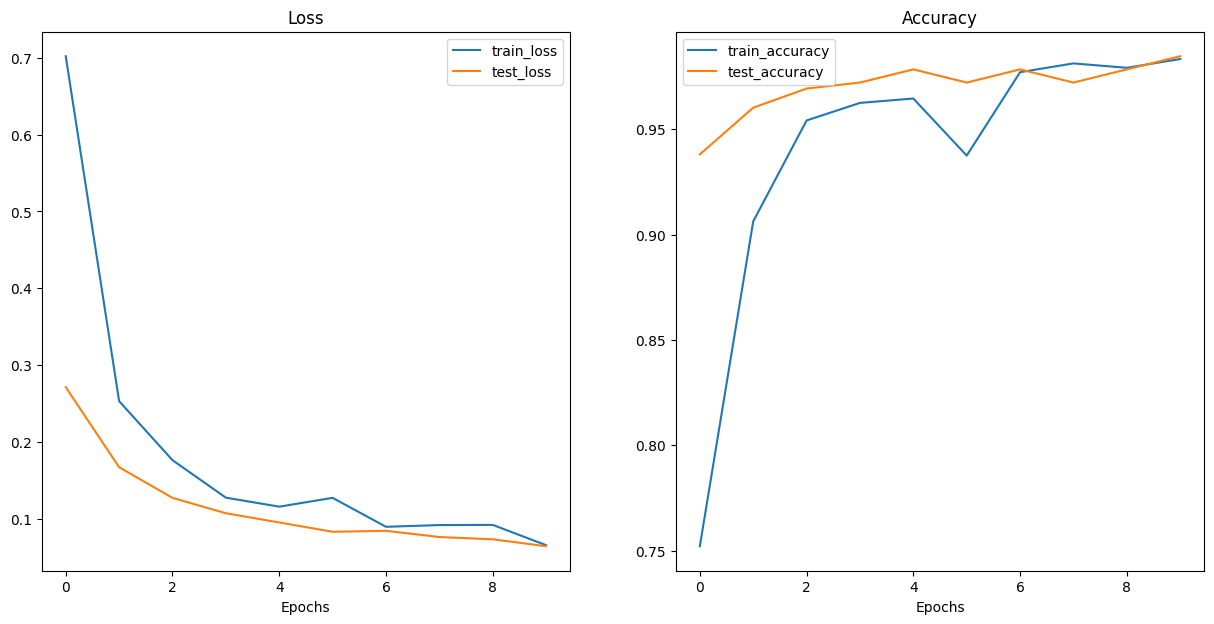

In [47]:
# plot the loss_curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [48]:
# Save the model
from going_modular.going_modular import utils

utils.save_model(model=pretrained_vit,
                target_dir="models",
                model_name="pretrained_vit_feature_extractor_pizza_steak_sushi.pth")

[INFO] Saving model to: models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth


In [49]:
from pathlib import Path
# get model size
pretrained_vit_model_size = Path("models/pretrained_vit_feature_extractor_pizza_steak_sushi.pth").stat().st_size // (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size}MB")

Pretrained ViT feature extractor model size: 327MB


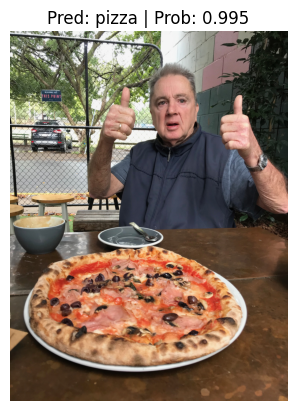

In [50]:
# Making predictions on custom image
import requests

# import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = image_path / "pizza-dad.jpeg"

# Donwload the image if it doesnt exist 
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download...")
          
# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                   image_path=custom_image_path,
                   class_names=class_names)